In [1]:
import pymc as pm
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import matplotlib.cm as cm
import pandas as pd
import pytensor.tensor as pt
import json
import scipy.stats as stats

In [36]:
def plot_posterior(trace,var_name,ax=None,**kwargs):
    if ax is None:
        ax=plt.subplot(111)
    data=getattr(trace.posterior,var_name).stack(sample=("chain","draw")).values
    sns.kdeplot(data,ax=ax,**kwargs)

Why use Bayesian emergent constraint model?  It respects causality.  ECS is the underlying quantity we care about.  Y is the response: an observable that depends on X.  Causally we assume the true ECS implies the observed Y: the response $Y$ is conditionally dependent on X and not the other way around.

In [77]:


def plot_posterior_hdi_mXb(
    trace,
    X,
    m_name="m",
    b_name="b",
    hdi_prob=0.95,
    ax=None,
    color="C0",
    label=None,
):
    """
    Plot posterior mean and HDI of m*X + b.

    Parameters
    ----------
    trace : arviz.InferenceData
        Posterior samples containing m and b.
    var_name : array
        array of X values at which to evaluate m*X + b.
    m_name : str
        Name of slope variable in the trace.
    b_name : str
        Name of intercept variable in the trace.
    hdi_prob : float
        HDI probability mass (default 0.95).
    ax : matplotlib axis or None
        Axis to plot on.
    color : str
        Line / band color.
    label : str or None
        Label for the mean line.

    Returns
    -------
    ax : matplotlib axis
    """

    if ax is None:
        fig, ax = plt.subplots()

    X = np.atleast_1d(X)
    X = np.sort(X)
    

    # Extract posterior samples and flatten chains
    m = trace.posterior[m_name].values.reshape(-1)
    b = trace.posterior[b_name].values.reshape(-1)

    # Compute posterior samples of m*X + b
    # shape: (nsamples, nX)
    Y = m[:, None] * X[None, :] + b[:, None]

    # Mean prediction
    Y_mean = Y.mean(axis=0)

    # HDI
    hdi = az.hdi(Y, hdi_prob=hdi_prob)

    # Plot
    ax.plot(X, Y_mean, color=color, label=label)
    ax.fill_between(
        X,
        hdi[:, 0],
        hdi[:, 1],
        color=color,
        alpha=0.3,
    )

    ax.set_xlabel("X")
    ax.set_ylabel("m·X + b")

    return ax


# Read in data
From https://esd.copernicus.org/articles/11/1233/2020/#section7

In [3]:
df=pd.read_excel("data/emergent_constraints/Schlund_esd-11-1233-2020-t06_CMIP6.xlsx")
# replace Unicode minus with ASCII minus
df = df.replace("−", "-", regex=True)

# convert all non-Model columns to numeric
for col in df.columns:
    if col != "Model":
        df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.drop(columns=["Unnamed: 0"], errors="ignore")
df = df.set_index("Model")
CMIP6 = xr.Dataset(df)


df=pd.read_excel("data/emergent_constraints/Schlund_esd-11-1233-2020-t05_CMIP5.xlsx")
# replace Unicode minus with ASCII minus
df = df.replace("−", "-", regex=True)

# convert all non-Model columns to numeric
for col in df.columns:
    if col != "Model":
        df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.drop(columns=["Unnamed: 0"], errors="ignore")
df = df.set_index("Model")
CMIP5 = xr.Dataset(df)


### Observations
From Brient and Schneider: Response of SW cloud reflectivity to SST changes is (-0.96+=0.22) (90%CL)
https://journals.ametsoc.org/view/journals/clim/29/16/jcli-d-15-0897.1.xml

From Zhai:  ±3σ (standard
error) (0.56%/K) around the observed αseason of 1.28 K.
https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1002/2015GL065911

In [4]:
ec_obs={}
ec_cmip={}
ec_obs_unc={}


ec_obs["ZHA"]= -1.28
ec_obs_unc["ZHA"] =0.56/3. # 3 sigma

ec_obs["BRI"] = -0.96
ec_obs_unc["BRI"] = 0.22/stats.norm.interval(.9)[1] #5-95 interval

In [5]:
def prep_data(constraint):
    data={}
    observable = getattr(CMIP6,constraint).rename({"Model":"model"})
    mask = ~np.isnan(observable)
    data["X"] = CMIP6.ECS.rename({"Model":"model"})[mask]
    data["Y"]= observable[mask]
    data["Y_obs"] = ec_obs[constraint]
    data["sigma_Y"] = ec_obs_unc[constraint]
    return data


In [69]:
def simple_ec_model(constraint):
    with pm.Model() as model:
        data=prep_data(constraint)
        X_true = pm.Normal("ECS",0,100)
        m = pm.Normal("m",0,5)
        b = pm.Normal("b",0,5)
        sigma_reg = pm.HalfNormal("sigma_reg",1)
        # learn m,b
        mu_sim = m*data["X"].values+b
        pm.Normal("Y_sim_lik",mu_sim,sigma_reg,observed=data["Y"].values)
        # emergent constraint
        mu_obs = m*X_true + b
        pm.Normal("Y_obs_lik",mu_obs,data["sigma_Y"],observed=[data["Y_obs"]])
    return model

In [71]:
with simple_ec_model("BRI"):
    britrace=pm.sample(target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ECS, m, b, sigma_reg]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
with simple_ec_model("ZHA"):
    zhatrace=pm.sample()

# Some emergent constraints are more constraining than others
The relationship between BRI and CMIP6 ECS is much weaker than ZHA and CMIP6 ECS.  So BRI is much less informative about ECS than ZHA.

/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_15288/3483856675.py:57: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(Y, hdi_prob=hdi_prob)
/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_15288/3483856675.py:57: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(Y, hdi_prob=hdi_prob)


(0.0, 20.0)

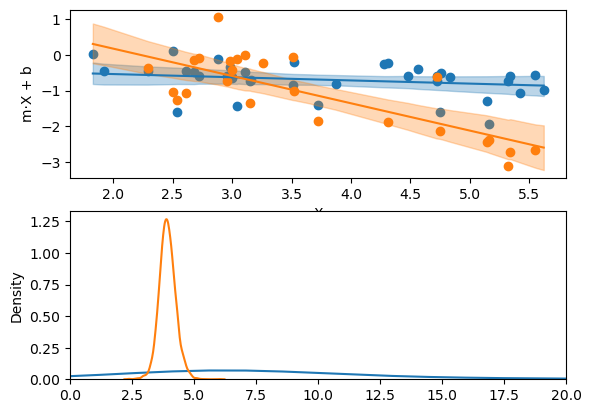

In [95]:
ax=plt.subplot(211)
bridata=prep_data("BRI")
plot_posterior_hdi_mXb(britrace,CMIP6.ECS.values,ax=ax)
#plot_posterior_hdi_mXb(zhatrace,CMIP6.ECS.values)
plt.scatter(bridata["X"],bridata["Y"])

zhadata=prep_data("ZHA")
plot_posterior_hdi_mXb(zhatrace,CMIP6.ECS.values,ax=ax,color=cm.tab10(1))
#plot_posterior_hdi_mXb(zhatrace,CMIP6.ECS.values)
plt.scatter(zhadata["X"],zhadata["Y"])

ax2=plt.subplot(212)
plot_posterior(britrace,"ECS",ax=ax2)
plot_posterior(zhatrace,"ECS",ax=ax2)
ax2.set_xlim(0,20)

In [12]:
from utils import load_data
feedback_evidence=load_data.feedback_dictionary(generation="CMIP6")

In [ ]:
# def add_emergent_constraint(
#     model: pm.Model,
#     var_name="X",      # name of latent CMIP X in the RE model
#     Y_cmip=None,         # CMIP-simulated observable (1 per model)
#     Y_obs=None,          # observed real-world value
#     Y_obs_sigma=None,    # observation uncertainty
#     priors={}            # optional priors for slope/intercept/EC scatter
# ):
#     """
#     Adds a single emergent constraint to an existing RE model
#     """
#     with model:
#         # latent X_m from RE model
#         X_m = model[var_name_m]

#         # 1) slope, intercept, scatter for EC
#         m = priors.get("m", lambda: pm.Normal("m", 0, 10))()
#         b = priors.get("b", lambda: pm.Normal("b", 0, 10))()
#         sigma_ec = priors.get("sigma_ec", lambda: pm.HalfNormal("sigma_ec", 1.0))()

#         # 2) CMIP ensemble likelihood to learn EC
#         pm.Normal("Y_cmip_lik", mu=m * X_m + b, sigma=sigma_ec, observed=Y_cmip)

#         # 3) Real-world observation likelihood
#         if (Y_obs is not None) and (Y_obs_sigma is not None):
#             X_true = model["X_true"]
#             pm.Normal("Y_obs_lik", mu=m * X_true + b, sigma=Y_obs_sigma, observed=Y_obs)


In [97]:
def use_noncentered(mu_iv, priors):
    # If IV is marginalized → non-centered is good
    if mu_iv is not None:
        return True

    # If sigma_iv is fixed to a small constant → centered is better
    if "sigma_iv" in priors:
        try:
            test = priors["sigma_iv"]("test")
            if np.isscalar(test) and test < 0.2:
                return False
        except Exception:
            pass

    # Default
    return True

def build_correlated_random_effects_model(data: xr.DataArray,
    priors={},
    var_name="X",
    mu_iv=None):
    
    """
    Build a hierarchical random-effects model for CMIP ensemble data in PyMC.

    This model implements a Bayesian correlated random-effects framework for estimating a latent
    “true” quantity across multiple ESMs while 
    accounting for both structural differences between ESMs and internal variability 
    within an ESM. The model supports:

    1. Latent correlated ESM means:
        - Each ESM mean X_m is assumed to be X_m = X_true + bias_m + bias_common
        - X_m is modeled as a multivariate normal (MVN) with
         correlation structure controlled by the shared parameter rho and a structural
         spread sigma_struct.  Rho is the fraction of variance explained by the common CMIP bias.
        - Non-centered parameterization is used to improve sampling efficiency in some cases

    2. Within-ESM internal variability:
       - If `mu_iv` is provided, internal variability sigma_iv is dominated completely by the prior
       and integrated out, yielding a Student-t likelihood:
           X_m^j ~ StudentT(nu, mu=X_m, sigma=exp(mu_iv))
         This is useful when each model has only 1 ensemble member.
       - Otherwise, sigma_iv is sampled explicitly  with optional
         per-model priors.  This is useful in e.g. detection and attribution where we have large model
         ensembles

    3. Correlation between model biases:
       - A common correlation rho is used to induce correlation among X_m values.
       - The correlation matrix is parameterized as (1-rho)*I + rho*J, where I is
         identity and J is a matrix of ones, and is factorized via Cholesky.

    Parameters
    ----------
    data : xr.DataArray
        CMIP ensemble data with dimensions that must include 'model'. Can have one or more
        ensemble members per model.
    priors : dict, optional
        Dictionary of callable prior constructors keyed by variable name. Supported keys:
        - 'X' or var_name: prior for the latent global mean.
        - 'sigma_struct': prior for structural spread across models.
        - 'sigma_iv': prior for internal variability (only used if mu_iv is None).
        - 'rho': prior for the correlation between model biases.
        If a key is absent, default weakly informative priors are used.
    var_name : str, default "X"
        Name of the latent quantity being estimated (used for naming PyMC variables).
    mu_iv : float or None, default None
        If provided, internal variability is fixed to mu_iv and
        the likelihood is Student-t, marginalizing sigma_iv. If None, sigma_iv is
        sampled explicitly using a HalfNormal or user-specified prior.
        Provide this if you think internal variability matters but you don't have sufficiently large ensembles
        If internal variability is known to be small (e.g. ECS) fix sigma_iv as a small constant instead.

    Returns
    -------
    vecmodel : pm.Model
        A PyMC model object representing the hierarchical random-effects model.

    Model Structure
    ---------------
    1. Global mean:
        X_true ~ Normal(0, 100) (default) or user-specified prior.
    
    2. Structural spread:
        sigma_struct ~ HalfNormal(1.0) (default) or user-specified prior.
    
    3. Correlation among ESM biases:
        rho ~ Beta(5, 5) (default) or user-specified prior.
    
    4. Latent ESM means:
        Data regime aware parameterization to ensure good geometry
        Both are statistically equivalent but trade off flexibility and speed
        
        (Centered, used when likelihood is sharp e.g. sigma_iv fixed or tiny)
        X_m ~ MVN(X_true, sigma_struct * (1-rho)I + rhoJ))
        
        (Non-centered, used when internal variability is weakly identified)
        z_m ~ Normal(0, 1)
        X_m = X_true + sigma_struct * Cholesky[(1-rho)*I + rho*J] @ z_m
    
    5. Within-model variability:
        - mu_iv is None: sigma_iv ~ HalfNormal(1.0) (per model) and
          likelihood: y_m ~ Normal(X_m, sigma_iv)
        - mu_iv provided: likelihood marginalizes sigma_iv:
          X_m^j ~ StudentT(nu=4, mu=X_m, sigma=exp(mu_iv))

    Notes
    -----
    - For single-member ensembles, mu_iv should be provided to use the Student-t likelihood.
    - Non-centered parameterization improves sampling efficiency for hierarchical X_m.
    - The Student-t likelihood encodes prior uncertainty in sigma_iv without slowing
      sampling in low-data regimes.
    """
    evidence_stacked = data.stack(run=("model",))
    
    # Unique models
    unique_models = np.unique(data.model.values)
    nmodels=len(unique_models)


    # Map model names to integers
    model_to_int = {name: i for i, name in enumerate(unique_models)}
    model_idx_int = np.array([model_to_int[m] for m in evidence_stacked["model"].values])
    with pm.Model(coords={"model": unique_models}) as vecmodel:
        
        # ======== Prior on the estimated quantity ============== #
        if var_name in priors.keys():
            X_true = priors[var_name](var_name)
        else:
            # Use a wide prior
            X_true = pm.Normal(var_name, 0, 100)
            
        # ======== Prior on CMIP structural spread ============== #
        if "sigma_struct" in priors.keys():
            sigma_struct = priors["sigma_struct"]("sigma_struct")
        else:
            sigma_struct = pm.HalfNormal("sigma_struct", 1.0)
            
         # ======== Prior on internal variability in each model =========#
        if mu_iv is None:
            # If mu_iv is specified, we assume sigma~iv,m ~ LogNormal(mu_iv,tau)
            # We then have y_m | X_m ~ StudentT
            #This is useful in cases where the uncertainty in iv is completely prior-dominated

            if "sigma_iv" in priors.keys():
                sigma_iv = priors["sigma_iv"]("sigma_iv")
            else:
                #Otherwise use a HalfNormal for sigma_iv
                sigma_iv = pm.HalfNormal("sigma_iv",
                                         1.0,
                                        dims="model")
            # Force it into a tensorvariable if it's a scalar
            sigma_iv = pt.as_tensor_variable(sigma_iv)


        # ======== Prior on correlation between biases =========#
        # for rho = constant, use priors["rho"] = lambda name: constant
        if "rho" in priors.keys():
            rho = priors["rho"]("rho")
        else:
            rho = pm.Beta("rho", alpha=5, beta=5)
        # Force it into a tensorvariable if it's a scalar
        rho = pt.as_tensor_variable(rho)

        # ======== Generate the correlation matrix =========#
        I = pt.eye(nmodels)
        J = pt.ones((nmodels, nmodels))
        corr = (1 - rho) * I + rho * J

        # Cholesky factor for speed
        #chol = sigma_struct * pt.linalg.cholesky(corr)
        chol_corr = pt.linalg.cholesky(corr)
        
        use_nc = use_noncentered(mu_iv, priors)

        # ======== Latent model means ======== #
        if use_nc:
            # ---- Non-centered ----
            z_m = pm.Normal("z_m", 0, 1, dims="model")

            X_m = pm.Deterministic(
                f"{var_name}_CMIP",
                X_true + sigma_struct * pt.dot(chol_corr, z_m),
                dims=("model",)
            )

        else:
            # ---- Centered ----
            X_m = pm.MvNormal(
                f"{var_name}_CMIP",
                mu=X_true * pt.ones(nmodels),
                chol=sigma_struct * chol_corr,
                dims=("model",)
            )

         # ======== Within-ensemble internal variability =========#
        # vectorized likelihood using integer index
        if mu_iv is not None:
            nu = 4

            pm.StudentT(
                f"{var_name}_lik",
                mu=X_m[model_idx_int],
                sigma=mu_iv,
                nu=nu,
                observed=evidence_stacked.values,
            )
        else:
            if len(sigma_iv.shape.eval()) > 0:
                pm.Normal(
                    f"{var_name}_lik",
                    mu=X_m[model_idx_int],
                    sigma=sigma_iv[model_idx_int],
                    observed=evidence_stacked.values,
                )
            else:
                pm.Normal(
                    f"{var_name}_lik",
                    mu=X_m[model_idx_int],
                    sigma=sigma_iv,
                    observed=evidence_stacked.values,
                )
    return vecmodel
    


In [46]:
data=prep_data("ZHA")

priors_ECS={}
priors_ECS["sigma_iv"] = lambda name:0.05
with test_build(CMIP6.ECS.rename({"Model":"model"}),var_name="ECS",priors=priors_ECS) as testmodel:
    pass
    #default_ECS_alldata = pm.sample(target_accept=.9)

In [66]:
bridata=prep_data("BRI")
with test_build(CMIP6.ECS.rename({"Model":"model"}),var_name="ECS",priors=priors_ECS) as ec2model:
    add_emergent_constraint(ec2model,\
                           "ECS",\
                           "ZHA",\
                           CMIP6.ZHA.rename({"Model":"model"}),\
                            data["Y_obs"],\
                            data["sigma_Y"])
    
    add_emergent_constraint(ec2model,\
                           "ECS",\
                           "BRI",\
                           CMIP6.BRI.rename({"Model":"model"}),\
                            bridata["Y_obs"],\
                            bridata["sigma_Y"])
        
    ectrace=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ECS, sigma_struct, rho, ECS_CMIP, m_ZHA, b_ZHA, regression_sigma_ZHA, m_BRI, b_BRI, regression_sigma_BRI]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


(0.0, 20.0)

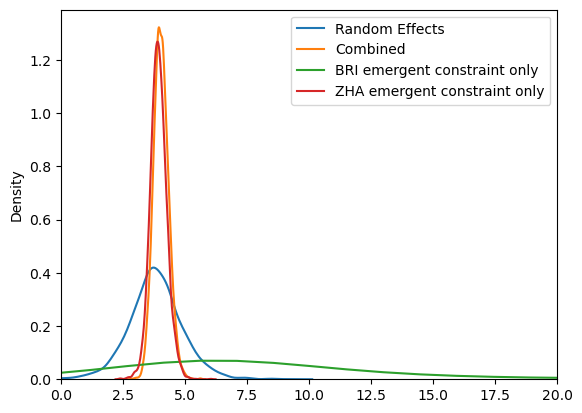

In [96]:

plot_posterior(default_ECS_alldata,"ECS",label="Random Effects")
plot_posterior(ectrace,"ECS",label="Combined")
plot_posterior(britrace,"ECS",label="BRI emergent constraint only")
plot_posterior(zhatrace,"ECS",label="ZHA emergent constraint only")
plt.legend()
plt.xlim(0,20)

In [64]:
def add_emergent_constraint(
    model,
    latent_var_name,
    observable_var_name,
    observable_CMIP,
    observable_obs,
    observable_obs_sigma,
    priors={}
):
    """
    Add an emergent constraint submodel:
        observable_CMIP = m latent_var_CMIP + b
        observable_obs ~ Normal(m X_true + b, observable_obs_sigma)
    """

    with model:
        # Inherit X_true and X_m from the random effects model
        X_true=model[f"{latent_var_name}"]
        X_m = model[f"{latent_var_name}_CMIP"]
        
        mask=~np.isnan(observable_CMIP.values)
        # ===== Regression parameters =====
        if "m" in priors:
            m = priors["m"](f"m_{observable_var_name}")
        else:
            m = pm.Normal(f"m_{observable_var_name}", 0, 5)

        if "b" in priors:
            b = priors["b"](f"b_{observable_var_name}")
        else:
            b = pm.Normal(f"b_{observable_var_name}", 0, 5)

        if "regression_sigma" in priors:
            sigma_Y = priors["regression_sigma"](f"regression_sigma_{observable_var_name}")
        else:
            sigma_Y = pm.HalfNormal(f"regression_sigma_{observable_var_name}", 1.0)

        # ===== Emergent relationship in the ensemble =====
        pm.Normal(
            f"{observable_var_name}_CMIP_lik",
            mu=m * X_m[mask] + b,
            sigma=sigma_Y,
            observed=observable_CMIP[mask].values,
        )

        # ===== Real-world emergent constraint =====
        pm.Normal(
            f"{observable_var_name}_obs_lik",
            mu=m * X_true + b,
            sigma=observable_obs_sigma,
            observed=observable_obs,
        )


In [ ]:
data = prep_data("ZHA")
var_name="ECS"

with build_random_effects_model(data["X"],mu_iv=0.01,var_name=var_name) as model0:

    add_emergent_constraint(model0,var_name,"ZHA",data["Y"],data["Y_obs"],data["sigma_Y"])
    ectrace=pm.sample()

In [ ]:
az.plot_posterior(trace01.posterior.X_m)

In [ ]:
az.plot_posterior(trace01.posterior.ECS)
az.plot_posterior(zhatrace.posterior.ECS,ax=plt.gca())

In [ ]:
def add_ec(model,latent_var_name,constraint):
    data=prep_data(constraint)
    with model:

        X_true = model[latent_var_name]
        X_m = model[f"{var_name}_CMIP"]
        
        m = pm.Normal("m",0,5)
        b = pm.Normal("b",0,5)
        sigma_reg = pm.HalfNormal("sigma_reg",1)
        # learn m,b
        mu_sim = m*X_m+b
        pm.Normal("Y_sim_lik",mu_sim,sigma_reg,observed=data["Y"].values)
        # emergent constraint
        mu_obs = m*X_true + b
        pm.Normal("Y_obs_lik",mu_obs,data["sigma_Y"],observed=[data["Y_obs"]])
    

In [ ]:
data = prep_data("ZHA")
var_name="ECS"

with build_random_effects_model(data["X"],mu_iv=0.01,var_name=var_name) as model0:

    trace=pm.sample(target_accept=.99)

In [ ]:
with model0:
    eczha=add_ec(model0,var_name,"ZHA")
    traceec=pm.sample()

In [ ]:
az.plot_posterior(trace.posterior.ECS)
az.plot_posterior(traceec.posterior.ECS,ax=plt.gca(),c="r")
az.plot_posterior(zhatrace.posterior.ECS,ax=plt.gca(),c="g")

In [ ]:
data["Y"]

In [ ]:
def add_marginalized_emergent_constraint(
    model,
    latent_var_name,
    observable_var_name,
    observable_CMIP,
    observable_obs,
    observable_obs_sigma,
    priors={}
):
    """
    Add an emergent constraint submodel:
        observable_CMIP = m latent_var_CMIP + b
        observable_obs ~ Normal(m X_true + b, observable_obs_sigma)
    But the sampler HATES this geometry
    So marginalize over 
    """

    with model:
        # Inherit X_true and X_m from the random effects model
        X_true=model[f"{latent_var_name}_CMIP"]
        X_m = model[f"{var_name}_CMIP"]
        
        mask=np.isnan(observable_CMIP.values)
        # ===== Regression parameters =====
        if "m" in priors:
            m = priors["m"]("m")
        else:
            m = pm.Normal("m", 0, 5)

        if "b" in priors:
            b = priors["b"]("b")
        else:
            b = pm.Normal("b", 0, 5)

        if "regression_sigma" in priors:
            sigma_Y = priors["regression_sigma"]("regression_sigma")
        else:
            sigma_Y = pm.HalfNormal("regression_sigma", 1.0)

        # ===== Emergent relationship in the ensemble =====
        pm.Normal(
            f"{observable_var_name}_CMIP_lik",
            mu=m * X_m[mask] + b,
            sigma=sigma_Y,
            observed=observable_CMIP[mask].values,
        )
        
        # ===== Real-world emergent constraint =====
#         Xbar = pt.mean(X_m)
#         Sxx = pm.math.sum((X_m - Xbar)**2)
#         sigma_ec = pm.Deterministic(
#             "sigma_ec",
#             sigma_Y * pm.math.sqrt(
#                 1
#                 + 1 / nmodels
#                 + (X_true - Xbar)**2 / Sxx
#             )
#         )
        sigma_ec = pm.Deterministic(
            "sigma_ec",
            sigma_Y * pm.math.sqrt(1 + 1 / nmodels)
        )
        pm.Normal(
            "Y_obs_lik",
            mu=m * X_true + b,
            sigma=pm.math.sqrt(observable_obs_sigma**2 + sigma_ec**2),
            observed=[observable_obs],
        )
        
#         pm.Normal(
#             f"{observable_var_name}_obs_lik",
#             mu=m * X_true + b,
#             sigma=observable_obs_sigma,
#             observed=[observable_obs],
#         )


In [ ]:
mask=~np.isnan(evidence["SWSST_CMIP"])
X=evidence["ECS_CMIP"][mask]
Y=evidence["SWSST_CMIP"][mask]
plt.scatter(X,Y)
X

In [ ]:

# Standardize X and Y (CMIP)
X_mean = np.nanmean(X.values)
X_std = np.nanstd(X.values)
Y_mean = np.nanmean(Y)
Y_std = np.nanstd(Y)

X_stdzd = (X.values - X_mean) / X_std
Y_stdzd = (Y - Y_mean) / Y_std

with pm.Model() as just_ec_std:
    # X_true stays in original units
    X_true = pm.Normal("X_true", 0, 10)

    # Regression in standardized space
    m_std = pm.Normal("m_std", 0, 5)
    b_std = pm.Normal("b_std", 0, 5)
    sigma_reg = pm.HalfNormal("sigma_reg", 1)

    # Likelihood for CMIP simulations (standardized)
    mu_cmip = m_std * X_stdzd + b_std
    pm.Normal("lik_cmip", mu=mu_cmip, sigma=sigma_reg, observed=Y_stdzd)

    # Likelihood for observation (rescale X_true to standardized X)
#     X_true_stdzd = (X_true - X_mean) / X_std
#     mu_obs = m_std * X_true_stdzd + b_std
#     pm.Normal(
#         "lik_obs",
#         mu=mu_obs,
#         sigma=evidence["SWSST_obs_unc"] / Y_std,  # scale obs sigma to standardized space
#         observed=[(evidence["SWSST_obs"] - Y_mean) / Y_std],
#     )

#     # Sample
    just_ec_trace = pm.sample(target_accept=0.95)


In [ ]:
az.plot_posterior(just_ec_trace)

In [ ]:
# Test it with just a regular prior
with pm.Model() as simplemodel:
    X_true = pm.Normal("ECS",0,10)
    X_m = pm.Data("ECS_CMIP",evidence["ECS_CMIP"][mask])
    
    add_emergent_constraint(simplemodel,
                            latent_var_name=var_name,
                            observable_var_name="SWSST",
                            observable_CMIP=evidence["SWSST_CMIP"][mask],
                            observable_obs=evidence["SWSST_obs"],
                            observable_obs_sigma=evidence["SWSST_obs_unc"])
    simpletrace=pm.sample()

In [ ]:
evidence

In [ ]:
observation_tuple=(np.ones(10)*evidence["SWSST_obs"]-evidence["SWSST_obs_unc"],\
                   np.ones(10)*evidence["SWSST_obs"]+evidence["SWSST_obs_unc"])
pmean=float(just_ec_trace.posterior.ECS.mean(dim=("chain","draw")).values)
psig=float(just_ec_trace.posterior.ECS.std(dim=("chain","draw")).values)

In [ ]:
plot_posterior_hdi_mXb(just_ec_trace,np.arange(0,10))
plt.fill_between(np.arange(0,10),*observation_tuple,color="r",alpha=.5)
plt.axvline(float(just_ec_trace.posterior.ECS.mean(dim=("chain","draw")).values))
plt.axvline(pmean-psig)
plt.axvline(pmean+psig)

In [ ]:
# build an uncorrelated random effects model
var_name="ECS"
priors ={}
priors["rho"] = lambda name: 0.0
with build_random_effects_model(evidence["ECS_CMIP"][mask],mu_iv=0.01,var_name=var_name,priors=priors) as model0:
        
    add_marginalized_emergent_constraint(model0,
                            latent_var_name=var_name,
                            observable_var_name="SWSST",
                            observable_CMIP=evidence["SWSST_CMIP"][mask],
                            observable_obs=evidence["SWSST_obs"],
                            observable_obs_sigma=evidence["SWSST_obs_unc"])
    ectrace=pm.sample()

In [ ]:
az.plot_posterior(ectrace.posterior.ECS)


In [ ]:
with pm.Model() as simplemodel:
    

In [ ]:
# build the random effects model

with build_random_effects_model(evidence["ECS_CMIP"],mu_iv=0.01,var_name="ECS") as remodel:
    trace01=pm.sample(return_inferencedata=True,target_accept=.99)

In [ ]:
with build_random_effects_model(evidence["ECS_CMIP"],mu_iv=0.01,var_name="ECS") as testmodel:
    add_emergent_constraint(testmodel,
    testmodel["X_m"],
    testmodel[var_name],
    evidence["SWSST_CMIP"],
    Y_obs,
    Y_unc,
    priors={}
)
    vecplus=pm.sample()

In [ ]:
az.plot_posterior(trace01.posterior.ECS)
az.plot_posterior(vecplus.posterior.ECS,ax=plt.gca(),c="r")

In [ ]:
var_name="ECS"
with build_random_effects_model(evidence["ECS_CMIP"],mu_iv=0.01,var_name=var_name) as addmodel:
    
    
    add_emergent_constraint(addmodel,
                            latent_var_name=var_name,
                            observable_var_name="SWSST",
                            observable_CMIP=evidence["SWSST_CMIP"],
                            observable_obs=evidence["SWSST_obs"],
                            observable_obs_sigma=evidence["SWSST_obs_unc"])
    ectrace=pm.sample()

In [ ]:
X=evidence["ECS_CMIP"].values
Y=evidence["SWSST_CMIP"].values
plt.scatter(X,Y)
mpost=float(ectrace.posterior.m.mean(dim=("chain","draw")))
bpost=float(ectrace.posterior.b.mean(dim=("chain","draw")))
plt.plot(X,mpost*X+bpost)

In [ ]:
def add_emergent_constraint(
    model: pm.Model,
    latent_var_name="X",
    observable_var_name="Y",
    observable_CMIP=None,         # CMIP-simulated observable (1 per model)
    observable_obs=None,          # observed real-world value
    observable_obs_sigma=None,    # observation uncertainty
    ecpriors={}            # optional priors for slope/intercept/EC scatter
):
    """
    Adds a single emergent constraint to an existing RE model
    """
    with model:
        # latent X_m from RE model
        X_m = model["X_m"]

        # 1) slope, intercept
        m = ecpriors.get("m", lambda: pm.Normal("m", 0, 10))()
        b = ecpriors.get("b", lambda: pm.Normal("b", 0, 10))()
        #Regression noise
        sigma_ec = ecpriors.get("sigma_ec", lambda: pm.HalfNormal("sigma_ec", 1.0))()

        # 2) CMIP ensemble likelihood to learn EC relationship
        pm.Normal(f"{observable_var_name}_cmip_lik", mu=m * X_m + b, sigma=sigma_ec, observed=observable_CMIP)

        # 3) Real-world observation likelihood
        if (observable_obs is not None) and (observable_obs_sigma is not None):
            X_true = model[latent_var_name]
            pm.Normal(f"{observable_var_name}_obs_lik", 
                      mu=m * X_true + b, 
                      sigma=observable_obs_sigma, 
                      observed=observable_obs)


In [ ]:
def plain_emergent_constraint(
    latent_var_name="X",
    observable_var_name="Y",
    observable_CMIP=None,         # CMIP-simulated observable (1 per model)
    observable_obs=None,          # observed real-world value
    observable_obs_sigma=None,    # observation uncertainty
    ecpriors={}            # optional priors for slope/intercept/EC scatter
):
    """
    Adds a single emergent constraint to an existing RE model
    """
    coords={"model":evidence["ECS_CMIP"].model.values}
    with pm.Model(coords=coords) as model:
        # latent X_m from RE model
        X_m = evidence["ECS_CMIP"].values

        # 1) slope, intercept
        m = ecpriors.get("m", lambda: pm.Normal("m", 0, 10))()
        b = ecpriors.get("b", lambda: pm.Normal("b", 0, 10))()
        #Regression noise
        sigma_ec = ecpriors.get("sigma_ec", lambda: pm.HalfNormal("sigma_ec", 1.0))()

        # 2) CMIP ensemble likelihood to learn EC relationship
        pm.Normal(f"{observable_var_name}_cmip_lik", mu=m * X_m + b, sigma=sigma_ec, observed=observable_CMIP)

        # 3) Real-world observation likelihood
        if (observable_obs is not None) and (observable_obs_sigma is not None):
            X_true = pm.Normal(latent_var_name,0,10)
            pm.Normal(f"{observable_var_name}_obs_lik", 
                      mu=m * X_true + b, 
                      sigma=observable_obs_sigma, 
                      observed=observable_obs)

    return model

In [ ]:
with plain_emergent_constraint(latent_var_name="ECS",
                            observable_var_name="SWSST",
                            observable_CMIP=evidence["SWSST_CMIP"],
                            observable_obs=evidence["SWSST_obs"],
                            observable_obs_sigma=evidence["SWSST_obs_unc"]):
    plaintrace=pm.sample()

In [ ]:
def posterior_mean(X,vari):
    return getattr(X.posterior,vari).mean(dim=("chain","draw"))

In [ ]:
Y=evidence["SWSST_CMIP"].values
X=np.ma.masked_where(np.isnan(Y),evidence["ECS_CMIP"]).compressed()
Y=np.ma.masked_where(np.isnan(Y),Y).compressed()
plt.scatter(X,Y)

In [ ]:
# just do a normal bayesian regression as a test

with pm.Model() as testmodel:
    m=pm.Normal("m",0,10)
    b=pm.Normal("b",0,10)
    mu=m*X+b
    sigma=pm.HalfNormal("sigma",10)
    pm.Normal("lik",mu=mu,sigma=sigma,observed=Y)
                  
    testtrace=pm.sample()

In [ ]:
Y_unc=evidence["SWSST_obs_unc"]
Y_obs=evidence["SWSST_obs"]

In [ ]:
# now add a constraint
with pm.Model() as constraintmodel:
    m=pm.Normal("m",0,10)
    b=pm.Normal("b",0,10)
    mu=m*X+b
    sigma=pm.HalfNormal("sigma",1)
    pm.Normal("lik_regress",mu=mu,sigma=sigma,observed=Y)
    Xtrue=pm.Normal("Xtrue",0,10)
    mu_obs=m*Xtrue+b
    pm.Normal("lik_Xtrue",mu=mu_obs,sigma=Y_unc,observed=Y_obs)
                  
    constrainttrace=pm.sample()

In [ ]:
with pm.Model() as ec_model:

    n = len(X)

    # emergent relationship
    m = pm.Normal("m", 0, 5)
    b = pm.Normal("b", 0, 5)
    sigma_Y = pm.HalfNormal("sigma_Y", 1)

    # true (latent) real-world X
    X_true = pm.Normal("X_true", 0, 10)

    # structural uncertainty
    sigma_struct = pm.HalfNormal("sigma_struct", 5)
    rho = pm.Beta("rho", 2, 2)   # keeps away from 0/1 boundaries

    # non-centered correlated random effects
    z_shared = pm.Normal("z_shared", 0, 1)
    z_ind = pm.Normal("z_ind", 0, 1, shape=n)

    X_sim = pm.Deterministic(
        "X_sim",
        X_true
        + sigma_struct * (
            pt.sqrt(rho) * z_shared
            + pt.sqrt(1 - rho) * z_ind
        )
    )

    # ensemble Y values
    pm.Normal(
        "Y_sim",
        m * X_sim + b,
        sigma_Y,
        observed=Y
    )

    # real-world observation
    pm.Normal(
        "Y_obs",
        m * X_true + b,
        Y_unc,
        observed=Y_obs
    )

    trace = pm.sample(target_accept=0.9)


In [ ]:
az.plot_posterior(constrainttrace,var_names=["Xtrue"])

In [ ]:
plt.scatter(X,Y)
m=float(posterior_mean(testtrace,"m"))
b=float(posterior_mean(testtrace,"b"))
mc=float(posterior_mean(constrainttrace,"m"))
bc=float(posterior_mean(constrainttrace,"b"))
plt.plot(X,m*X+b,ls="--",c=cm.tab10(1))
plt.plot(X,mc*X+bc,ls="--",c=cm.tab10(2))
plt.axhline(evidence["SWSST_obs"])
plt.axhline(evidence["SWSST_obs"]-2*evidence["SWSST_obs_unc"],ls=":",c="k")
plt.axhline(evidence["SWSST_obs"]+2*evidence["SWSST_obs_unc"],ls=":",c="k")
# plt.fill_between(sorted(X),evidence["SWSST_obs"]-evidence["SWSST_obs_unc"],
#                 evidence["SWSST_obs"]+evidence["SWSST_obs_unc"])
# p=np.polyfit(X,Y,1)
# plt.plot(X,np.polyval(p,X))

In [ ]:
az.plot_posterior(plaintrace,var_names=["ECS"])

In [ ]:
with remodel:
    add_emergent_constraint(
        remodel,
        var_name="ECS",      # name of latent CMIP X in the RE model
        Y_cmip=,         # CMIP-simulated observable (1 per model)
    Y_obs=None,          # observed real-world value
    Y_obs_sigma=None,    # observation uncertainty
    priors={}            # optional priors for slope/intercept/EC scatter
)

In [ ]:
az.plot_posterior(trace.posterior.ECS)
az.plot_posterior(trace01.posterior.ECS,ax=plt.gca(),c="r")

In [ ]:
with remodel:
    trace.extend(pm.sample_prior_predictive(samples=2000,var_names=["rho","ECS"]))

In [ ]:
fig, ax = plt.subplots()
az.plot_density(
    trace,
    var_names=["ECS"],
    group="prior",
    ax=ax,
    colors=["gray"],
    shade=0.3
)

az.plot_density(
    trace,
    var_names=["ECS"],
    group="posterior",
    ax=ax,
    colors=["C0"],
    shade=0.6
)


In [ ]:
az.plot_posterior(trace.posterior.ECS)    

In [ ]:
X=evidence["X_CMIP"]
Y=evidence["obs_CMIP"]

plt.scatter(evidence["X_CMIP"],evidence["obs_CMIP"])
m0,b0=np.polyfit(evidence["X_CMIP"],evidence["obs_CMIP"],1)
mflip,bflip=np.polyfit(evidence["obs_CMIP"],evidence["X_CMIP"],1)
mpost=ectrace.posterior.m.mean(dim=("chain","draw"))
bpost=ectrace.posterior.b.mean(dim=("chain","draw"))

mpost2=standardtrace.posterior.m.mean(dim=("chain","draw"))
bpost2=standardtrace.posterior.b.mean(dim=("chain","draw"))

p=[mpost,bpost]
p0=[m0,b0]
p2=[mpost2,bpost2]
plt.plot(evidence["X_CMIP"],np.polyval(p,evidence["X_CMIP"]),label="EIV")
plt.plot(evidence["X_CMIP"],np.polyval(p0,evidence["X_CMIP"]),label="LSQ")
plt.plot(evidence["X_CMIP"],np.polyval(p2,evidence["X_CMIP"]),label="std bayes")
plt.legend()


In [ ]:


# Simulated data
obs_sim = evidence["obs_CMIP"]  # shape (N,)
X_sim = evidence["X_CMIP"]      # shape (N,)

# Observed real-world data
obs_real = evidence["obs"]                        # scalar
obs_uncertainty = evidence["obs_unc"]            # scalar

with pm.Model() as emergent_constraint_model:

    # --- Priors for linear regression parameters ---
    alpha = pm.Normal("alpha", mu=0, sigma=10)   # intercept
    beta = pm.Normal("beta", mu=0, sigma=10)     # slope
    sigma = pm.HalfNormal("sigma", sigma=1)      # scatter in simulated relationship

    # --- Likelihood for simulated data ---
    mu_sim = alpha + beta * X_sim
    pm.Normal("obs_sim_likelihood", mu=mu_sim, sigma=sigma, observed=obs_sim)

    # --- Likelihood for real-world observation ---
    # Introduce latent variable for real-world X
    X_real = pm.Normal("X_real", mu=np.mean(X_sim), sigma=np.std(X_sim))  # prior for unknown X

    mu_obs_real = alpha + beta * X_real
    pm.Normal("obs_real_likelihood", mu=mu_obs_real, sigma=obs_uncertainty, observed=obs_real)

    # --- Sample posterior ---
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Extract posterior for real-world X
posterior_X = trace.posterior["X_real"]


In [ ]:
az.plot_posterior(trace,var_names=["X_real"])
sns.kdeplot(evidence["X_CMIP"])

In [ ]:
priors={}

priors["m"] = lambda name:pm.Normal(name,m0,np.abs(m0)*.5)
priors["b"] = lambda name:pm.Normal(name,b0,np.abs(b0)*.5)

with pm.Model() as standardmodel:
# Hyperpriors on slope and intercept
    if "m" in priors.keys():
        m = priors["m"](name="m")
    else:
        m=pm.Normal("m",0,100)
    if "b" in priors.keys():
        b = priors["b"](name="b")
    else:
        b=pm.Normal("b",0,100)
    sigma=pm.HalfNormal("sigma",1)
    pm.Normal("lik",mu=m*X,sigma=sigma,observed=evidence["obs_CMIP"])
    standardtrace=pm.sample()

In [ ]:
priors={}
priors["X"]=lambda name: pm.Normal(name,3,2)
priors["m"] = lambda name:pm.Normal(name,m0,np.abs(m0)*.5)
priors["b"] = lambda name:pm.Normal(name,b0,np.abs(b0)*.5)

In [ ]:
def make_emergent_constraint_model(model,evidence,priors,var_name="X"):
    """
    X is the quantity we wish to constrain
    evidence: dict object with keys ["obs_CMIP","obs_CMIP_unc",obs","obs_unc","X_CMIP","X_CMIP_unc"]
    """
    with model:
        ### EMERGENT CONSTRAINT ###
        # EMERGENT CONSTRAINT ON TROPICAL γLT
        n_models_EC=len(evidence['X_CMIP'])
        X=priors["X"](name=var_name)
            #Assume linear relationships
        # Hyperpriors on slope and intercept
        if "m" in priors.keys():
            m = priors["m"](name="m")
        else:
            m=pm.Normal("m",0,100)
        if "b" in priors.keys():
            b = priors["b"](name="b")
        else:
            b=pm.Normal("b",0,100)
        
        if not ("X_CMIP_unc" in evidence.keys()):
            x_true=evidence['X_CMIP']
        else:

            # Errors-in-variables model for model X
            x_true = pm.Normal("X_CMIP", mu=evidence['X_CMIP'], \
                               sigma=evidence['X_CMIP_unc'], \
                               shape=n_models_EC)

        # Linear model for "true" observable values
        y_true = m * x_true + b

        # Likelihood of observable values in CMIP
        y_likelihood = pm.Normal("obs_CMIP", mu=y_true, \
                                 sigma=evidence['obs_CMIP_unc'],\
                                 shape=n_models_EC,\
                                 observed=evidence['obs_CMIP'])
        #Emergent constraint relationship

        mu_obs = m * X + b
       
        obs_true=pm.Normal("obs_true",mu=mu_obs,\
                           sigma=evidence["obs_unc"],\
                           observed = [evidence["obs"]])
        return {var_name:X}



In [ ]:
with pm.Model() as ecmodel:
    params=make_emergent_constraint_model(ecmodel,evidence,priors,var_name="ECS")
    ectrace=pm.sample()

In [ ]:
az.plot_posterior(ectrace)


In [ ]:
with pm.Model() as model:
    model = make_emergent_constraint_model(
        model,
        evidence,
        priors={"X":lambda name: pm.Normal(name,3,2),"m_sigma": 1.0, "b_sigma": 1.0},
        var_name="X"
    )

    trace = pm.sample(
        tune=1000,
        draws=1000,
        chains=4,
        target_accept=0.9,
    )